# Shor's Reference Implementation

Please see the book chapters for a full explanation of the algorithm.  (Note: This chapter is not released yet as this is a draft.)

This example follows Shor's initial article  https://arxiv.org/abs/quant-ph/9508027v2 and its summary https://arxiv.org/abs/1301.7007v1 by John A. Smolin, Graeme Smith and Alex Vargo. 

The code implementation will work for 

In [12]:
import numpy as np
from math import ceil, sqrt, log2
from random import randint
from sympy import mod_inverse
from fractions import Fraction

from qiskit import execute, Aer, IBMQ 
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute
import learn_quantum as lq
from learn_quantum import ket
from IPython.display import Latex

from numpy import pi, pi as π, cos, sin, exp, gcd, lcm

import matplotlib.pyplot as plt

The main number to factor is typically referred to as "N", but because of the common use of "n" in code, nilf is used instead.  Number I'd Like to Factor.

In [67]:
nilf = 15  # Number I'd Like to Factor

Chose $S \equiv 2^{B}$ such that  $N^2 \leq S \lt 2N^2$.

Chose (at random) as an integer $1 < a < N$. 

In [68]:
nilf_bit_size = ceil(log2(nilf))
register_1_size = ceil(log2(nilf**2)) # not always 2*nilf_bit_size
register_2_size = nilf_bit_size

a = randint(2, nilf-1)
## but I'll hardcode to 7 so the initial code lines up with Latex
a = 7

## check that it is not already a factor and that the nilf is not a square
if gcd(a, nilf) > 1:
    print('a is a factor. Chose a different a')
for k in range(2, 5):
    if nilf**(1/k) == int(nilf**(1/k)):
        print('this nilf is square')



In [69]:
print('S={}, N^2={}, 2N^2={}'.format(2**(register_1_size), nilf**2, 2*nilf**2))

S=256, N^2=225, 2N^2=450


## Perform the initial quantum fourier transformation 

Construct the quantum state $$\frac{1}{\sqrt{S}}\sum_{x=0}^{S-1} \vert x \rangle \vert 0 \rangle$$

This is created by peforming a Fourier transformation on the first register.  As with Period Estimation, because the initial state is $ \vert 0 \rangle$, this amounts to only Hadamard gates.

This uses two registers, the first is B-qubits ( from $S \equiv 2^{B}$)  and the second is $log_2 N$.

In [70]:
print('Reg 1 size:{}, Reg 2 size:{}'.format(register_1_size, register_2_size))

Reg 1 size:8, Reg 2 size:4


In [71]:
reg_1 = QuantumRegister(register_1_size) 
reg_2 = QuantumRegister(register_2_size)
qc = QuantumCircuit(reg_1, reg_2)

qc.h(reg_1)


In [72]:
#setup a function to handle the formating of the state vector
def shor_state_vector(qc, split, factor=True):
    return lq.show_state_vector(qc, integer=True, factor=factor, split=split, truncate=128, split_color='#C00')

### Check the state vector matches the math

The output of the state vector is the mathmatical format expanded:

$$\frac{1}{\sqrt{S}}\sum_{x=0}^{S-1} \vert x \rangle \vert 0 \rangle$$

$ = \frac{1}{\sqrt{S}} \left(  \vert 0 \rangle \vert 0 \rangle +  \vert 1 \rangle \vert 0 \rangle +  \vert 2 \rangle \vert 0 \rangle \ldots  \vert S-1 \rangle \vert 0 \rangle \right)$

In [73]:
Latex(shor_state_vector(qc, register_1_size))

<IPython.core.display.Latex object>

# Map onto $a^x mod N$
Map the state $\vert x \rangle\vert 0 \rangle$ to $\vert x \rangle\vert a^x mod N \rangle$.

Doing this with quantum operations would exceed the circuit space available, so put it into a classical calulation and load the result into the quantum simulator.

In [74]:
def compute_state_vector(nilf, a, register_1_size, register_2_size):
    bit_size = ceil(log2(nilf))
    total_size = register_1_size + register_2_size
    
    state_vector = np.zeros((2**total_size, 1), dtype=complex)
    power = 1
    for k in range(2**(register_1_size)):
        binary_k = lq.int_to_binary_string(k, register_1_size)
        binary_power = lq.int_to_binary_string(power, register_2_size)
        binary_k = binary_k[::-1]
        binary_power = binary_power[::-1]
        state_vector = state_vector + np.kron(ket(binary_power), ket(binary_k))
        power = int(power) * int(a) % int(nilf)
        # for larger nilf's, provides a status
        if k+1 % 1000 == 0:
            print('{} of {}'.format(k, 2**(register_1_size)))
    state_vector = state_vector / sqrt(2**(register_1_size))
    return state_vector.reshape(2**(total_size),)

Formally: $$\frac{1}{\sqrt{S}}\sum_{x=0}^{S-1} \vert x \rangle \vert a^x mod \; n \rangle$$  (Note that the "a" and "x" are reversed between Shor's article and Smolin's.  Here, I use Smolin's a as the base.)

In [75]:
reg_1 = QuantumRegister(register_1_size) 
reg_2 = QuantumRegister(register_2_size)
cr = ClassicalRegister(register_1_size)  ## to measure output
qc = QuantumCircuit(reg_1, reg_2, cr)

modular_vector = compute_state_vector(nilf, a, register_1_size, register_2_size)
qc.initialize(modular_vector, [reg_1, reg_2])



The numbers in red are $a^x$ mod $N$.  If the transformation is done correctly, there are $S$ of these starting at 0 and going to $S-1$.  

In [76]:
Latex(shor_state_vector(qc, register_1_size))

<IPython.core.display.Latex object>

In [77]:
# if Latex is too long, use:
#lq.print_state_vector(qc, integer=True, split=register_1_size)

Because $N^2 \leq S \lt 2N^2$, this state vector always contains the period, but we cannot read it directly in a real quantum computer.  As such, use a quantum Fourier transformation to condense it to the overlaping numbers.  That is, map it onto: $$\frac{1}{S}\sum_x \sum_y e^{(2\pi i/S)xy} \vert y \rangle \vert a^x mod \; n \rangle$$



In [78]:
def textbook_qft(circuit, qr_1, n, start_at=0):
    
    for j in range(n + start_at):
        circuit.h(qr_1[j])
        for k in range(j + 1 + start_at, n + start_at):
            circuit.cu1(np.pi/float(2**(k-j)), qr_1[k], qr_1[j])
    
    for i in range(n//2 + start_at):
        circuit.swap(qr_1[i], qr_1[n-i-1])
    

In [79]:
qft = QuantumCircuit(reg_1, reg_2, cr)
textbook_qft(qft, reg_1, register_1_size)
qft = qft.inverse()

In [80]:
Latex(shor_state_vector(qc + qft, register_1_size))

<IPython.core.display.Latex object>

In [81]:
# if Latex is too long, use:
#lq.print_state_vector(qc + qft.inverse(), integer=True, split=register_1_size)

The "show_state_vector" routine uses show_zeros=False by default. The QFT maps all the other terms to 0. When the register size is an exact multiple of the period, it gives an exact result and the size of the displayed state vector will be small. 

Essentially, the QFT is displaying the frequency information from the previous state vector. 

## Measurement
Add a measurment and compute the period.  The math behind this is fairly interesting and is covered in the book. But the code is simple as it is convered by the Fraction module.

Shor's original paper covered a single measurement.  In modern quantum computers, performing multiple measurements once the circuit has been set up is fairly fast, so I'll first cover the single measurment situation and then multile-measurments.

If the period is odd or $a^{r/2} = -1 $ mod $N$, it will not find a factor (in most cases). A factor is found by the greatest common divisor of $a^{r/2} \pm 1$ and $N$. 

Rather than performing various checks, for small numbers, it is easiest to try to get the factor. 

In [82]:
def check_factor(nilf, r, a):
    a = int(a)
    p = int(r/2)

    power = pow(a, p, nilf)
    g1 = gcd(power+1, nilf)
    if g1>1 and g1<nilf and nilf/g1 == int(nilf/g1):
        return g1
    
    g2 = gcd(power-1, nilf)
    if g2 >1 and g2<nilf and nilf/g2 == int(nilf/g2):
            return g2
        
    return -1

In [83]:
m = QuantumCircuit(reg_1, reg_2, cr)
m.measure(reg_1, cr)
shots = 1
answers = lq.execute_simulated(qc + qft + m ,shots)
k = next(iter(answers))
val = int(lq.reverse_string(k),2)
period = Fraction(val/(2**register_1_size)).limit_denominator(nilf-1).denominator
print(check_factor(nilf, period, a))

3


## Plot the results to visually see the periods

The number of peaks corresponds to the period.  

In [84]:
def format_plot_data(answers, threshold):
    first_key = next(iter(answers))
    bit_size = len(first_key)
    x_axis_data = np.arange(0, 2**bit_size)
    y_axis_data = []
    tick_marks = np.array([0,2**bit_size])
    last_tick_mark = 0
    for x in x_axis_data:
        key = lq.int_to_binary_string(x, bit_size, reverse=True)
        if key in answers:
            y_axis_data.append(answers[key])
            if answers[key] >= threshold:
                if x - last_tick_mark > bit_size**2:
                    tick_marks = np.append(tick_marks, x)
                    last_tick_mark = x
        else:
            y_axis_data.append(0)
    return x_axis_data, y_axis_data, tick_marks

def plot_integer_results(answers, threshold):
    
    x_axis_data, y_axis_data, tick_marks = format_plot_data(answers, threshold)

    fig, axes = plt.subplots(1, 1, figsize=(15,5))

    plt.bar(x_axis_data, y_axis_data)
    plt.xticks(tick_marks)
    plt.show()

In [85]:
shots = 1000
answers = lq.execute_simulated(qc + qft + m ,shots)

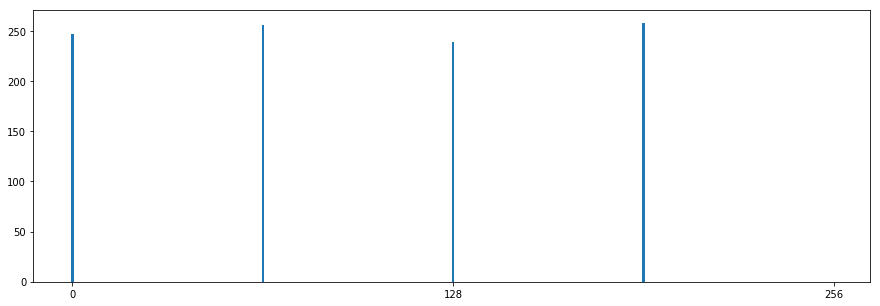

In [86]:
plot_integer_results(answers, 0)